## **Extracting frames from the video and cropping it and converting it into grey scale**

In [8]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt


def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for i in range(frame_count):
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames



def crop_frames(frames, x, y, width, height):
    cropped_frames = []

    for frame in frames:
        cropped_frame = frame[y:y+height, x:x+width]
        cropped_frames.append(cropped_frame)

    return cropped_frames

def convert_to_bw(frames):
    bw_frames = []

    for frame in frames:
        bw_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        bw_frames.append(bw_frame)

    return bw_frames

# Specify the path to the video file
video_path = '/content/video.mp4'

# Specify the cropping dimensions
x = 70  # x-coordinate of the top-left corner of the crop
y = 90  # y-coordinate of the top-left corner of the crop
width = 1140  # width of the crop
height = 450  # height of the crop


# Extract frames from the video
frames = extract_frames(video_path)

# Crop the frames
cropped_frames = crop_frames(frames, x, y, width, height)

# Convert the cropped frames to black and white
bw_frames = convert_to_bw(cropped_frames)

print("frames cropped and extracted ans stored in bw_frames")

frames cropped and extracted ans stored in bw_frames


### **Finding the pixel intensities of hole in the video**

Maximum pixel intensity in the hole :
98


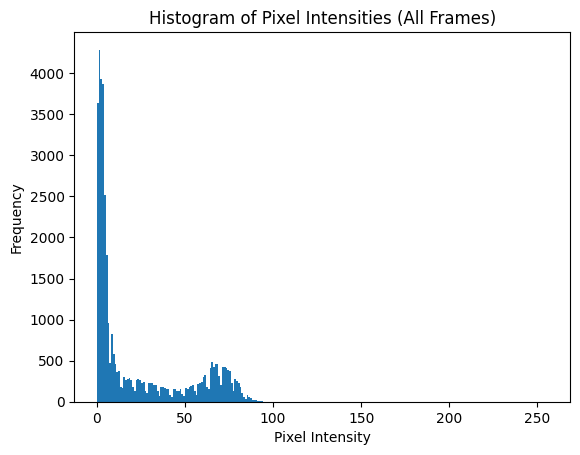

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Define the region of interest (rectangle coordinates)
roi_x = 433  # X-coordinate of the top-left corner of the rectangle
roi_y = 264  # Y-coordinate of the top-left corner of the rectangle
roi_width = 8  # Width of the rectangle
roi_height = 8  # Height of the rectangle

pixel_values = []

# Process each frame of the video

for frame in bw_frames:
    # Extract the region of interest
    roi = frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]

    # Convert the region of interest to grayscale
    #gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Accumulate pixel values
    pixel_values.extend(roi.flatten())



# Calculate the histogram of pixel intensities using NumPy
histogram, bin_edges = np.histogram(pixel_values, bins=256, range=[0, 256])
print("Maximum pixel intensity in the hole :")
print(max(pixel_values))
# Plot the histogram
plt.hist(pixel_values,bin_edges )
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Intensities (All Frames)')
plt.show()


# Finding Midpoints of the ball in each frame

In [ ]:
def find_ball_midpoints(frames):
    midpoint_list = []

    for index, frame in enumerate(frames):

           # Apply a threshold to convert the image to binary (black and white)
           _, binary = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)

           y_coords, x_coords = np.nonzero(binary) #getting ball pixels only


           if len(y_coords) > 0:


                # Find the starting pixels in each direction
               top_pixel = (np.min(x_coords), np.min(y_coords))
               bottom_pixel = (np.max(x_coords), np.max(y_coords))

               # Calculate the mid pont  of rectangle  using the starting pixels
               midpoint_x = (top_pixel[0] + bottom_pixel[0]) / 2
               midpoint_y = (top_pixel[1] + bottom_pixel[1]) / 2

               print((index,int(midpoint_x), 450 - int(midpoint_y)))
               midpoint_list.append((index,int(midpoint_x), 450 - int(midpoint_y)))
           else:
               print((index, 0, 0))

    return midpoint_list


midpoints = find_ball_midpoints(bw_frames)


## **From midpoints, seperating frame numbers, x and y co-ordinates. Calculating delta x,delta y, delta y/delta x which is slope**

In [14]:
# Extract frame_no, x, and y coordinates from the midpoints tuples
frame_nos = [t[0] for t in midpoints]
x_coords = [t[1] for t in midpoints]
y_coords = [t[2] for t in midpoints]

# Calculate delta x
delta_x = np.diff(x_coords)

# Calculate delta y
delta_y = np.diff(y_coords)

# Calculate delta y / delta x which is tan (theta)
delta_ratio = np.divide(delta_y, delta_x)
print("input data is ready")

input data is ready


Plotting frame number versus slope graph

Frame number when slope is root 3
179


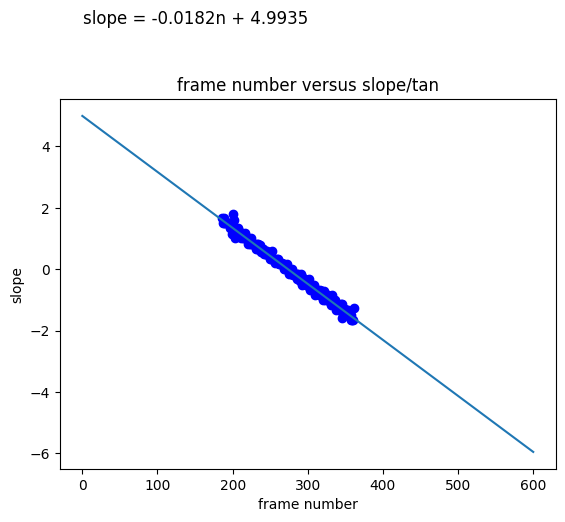

In [22]:
# Fit a linear regression line to the coordinates
coefficients = np.polyfit(frame_nos[:-1], delta_ratio, 1)
m, b = coefficients

# Generate x values for the plot
n = np.linspace(0, 600, 100)

# Calculate y values based on the linear equation
slope = m * n + b

# When slope is sqare root 3, finding the frame number

print("Frame number when slope is root 3")

print ( round((np.sqrt(3) - b ) / m) )

# Plot the linear graph
plt.plot(n, slope, label='Linear Graph')

# Plot the original coordinates
plt.scatter(frame_nos[:-1], delta_ratio, color='blue', label='Coordinates')

# Print the equation on the graph
equation = f"slope = {m:.4f}n + {b:.4f}"
plt.text(1, 8, equation, fontsize=12)

plt.xlabel('frame number')
plt.ylabel('slope')
plt.title('frame number versus slope/tan')
plt.show()


## **Plotting frame number vs x graph . Hence finding x co-ordinate of origin**\

The x value where frame number is 179 :
6


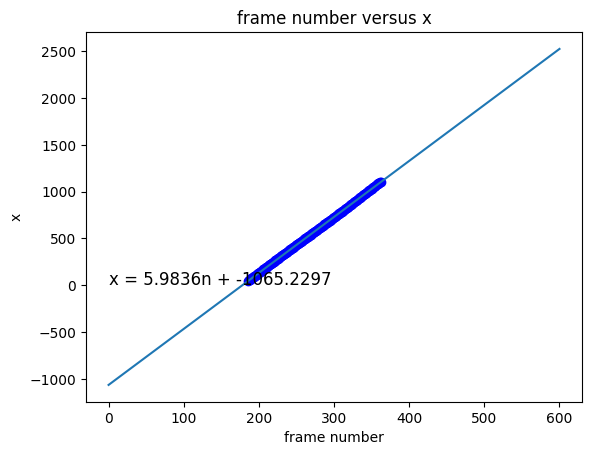

In [24]:
# Fit a linear regression line to the coordinates
coefficients = np.polyfit(frame_nos, x_coords, 1)
m, b = coefficients

# Generate x values for the plot
n = np.linspace(0, 600, 100)

# Calculate x values based on the linear equation
x = m * n + b

print("The x value where frame number is 179 :")
print( round((m * 179) + b))

# Plot the linear graph
plt.plot(n, x, label='Linear Graph')

# Plot the original coordinates
plt.scatter(frame_nos, x_coords, color='blue', label='Coordinates')

# Print the equation on the graph
equation = f"x = {m:.4f}n + {b:.4f}"
plt.text(1, 8, equation, fontsize=12)

plt.xlabel('frame number')
plt.ylabel('x')
plt.title('frame number versus x')
plt.show()


### **Plotting frame number versus Y co-ordinate . Hence finding Y co-ordinate of orgin**

Value of Y co ordinate when frame number is 179:
-65


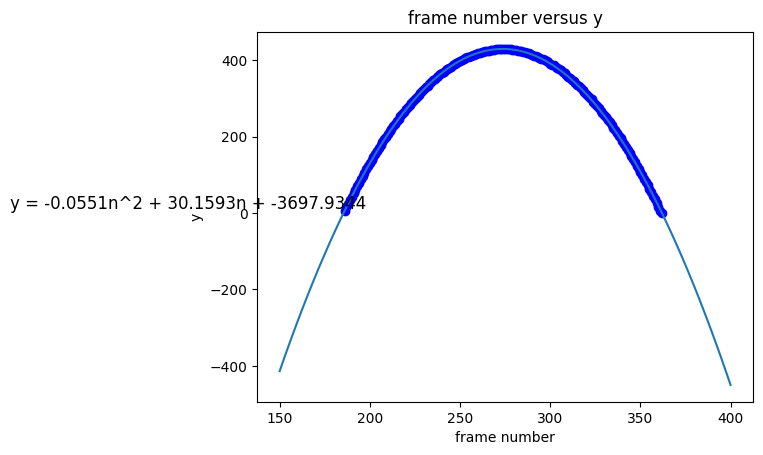

In [30]:
# Fit a quadratic curve to the coordinates
coefficients = np.polyfit(frame_nos, y_coords, 2)
a, b, c = coefficients

# Generate x values for the plot
n = np.linspace(150, 400, 100)

# Calculate y values based on the quadratic equation
y = a * n**2 + b * n + c

print("Value of Y co ordinate when frame number is 179:")
print( round( (a * 179 * 179) + (b * 179) + c  ))

# Plot x versus y
plt.plot(n, y)
plt.scatter(frame_nos, y_coords, color='blue', label='Coordinates')

# Print the equation on the graph
equation = f"y = {a:.4f}n^2 + {b:.4f}n + {c:.4f}"
plt.text(0.5, 10, equation, fontsize=12)

plt.xlabel('frame number')
plt.ylabel('y')
plt.title('frame number versus y')
plt.show()

**Plotting x vs y graph . Hence finding range and maximum height**

(5.107516799713057, 1143.0763517698526)


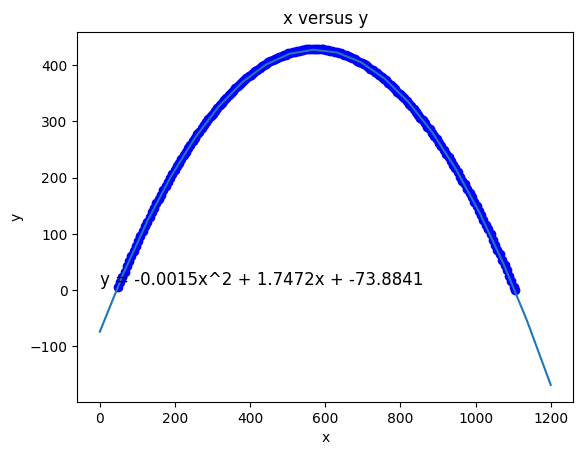

In [28]:
import math

# Fit a quadratic curve to the coordinates
coefficients = np.polyfit(x_coords, y_coords, 2)
a, b, c = coefficients

# Generate x values for the plot
x = np.linspace(0, 1200, 20)

# Calculate y values based on the quadratic equation
y = a * x**2 + b * x + c


# Origin is at (6,-65) .
# Finding Range
# Finding X co ordinates where y = - 65 using the equation

def solve_quadratic(a, b, c):
    # Calculate the discriminant
    discriminant = b**2 - 4*a*c

    # Check if the equation has real roots
    if discriminant < 0:
        return None  # No real roots exist

    # Calculate the roots
    root1 = (-b + math.sqrt(discriminant)) / (2*a)
    root2 = (-b - math.sqrt(discriminant)) / (2*a)

    return root1, root2

roots = solve_quadratic(a,b,c+65)

print (roots)




# Plot x versus y
plt.plot(x, y)
plt.scatter(x_coords, y_coords, color='blue', label='Coordinates')

# Print the equation on the graph
equation = f"y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}"
plt.text(0.5, 10, equation, fontsize=12)

plt.xlabel('x')
plt.ylabel('y')
plt.title('x versus y')
plt.show()

# **Hence 1143 - 6 = 1137 is the pixel range. 1137 / 797 = 1.4266 meters is the range of the projectile**

## **X co ordinate of maximum height is (6+ 1143) / 2 = 574.5 . Finding Y co- ordinate at this x value using the equation**

In [35]:
((-0.0015 * 574.5 * 574.5) + ( 1.7472 * 574.5) - 73.8841 ) / 797


0.5455544855708909

# **So 0.546 is the maximum height of the projectile **

### **Plotting frame number versus delta x graph**

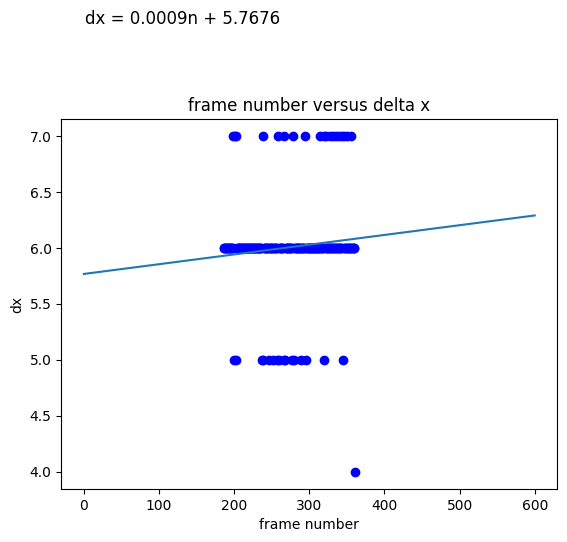

In [36]:
# Fit a linear regression line to the coordinates
coefficients = np.polyfit(frame_nos[:-1], delta_x, 1)
m, b = coefficients

# Generate x values for the plot
n = np.linspace(0, 600, 100)

# Calculate y values based on the linear equation
dx = m * n + b

# Plot the linear graph
plt.plot(n, dx, label='Linear Graph')

# Plot the original coordinates
plt.scatter(frame_nos[:-1], delta_x, color='blue', label='Coordinates')

# Print the equation on the graph
equation = f"dx = {m:.4f}n + {b:.4f}"
plt.text(1, 8, equation, fontsize=12)

plt.xlabel('frame number')
plt.ylabel('dx')
plt.title('frame number versus delta x')
plt.show()

Horizontal velocity is 5.7676 pixel per frame.

In [37]:
(5.7676/ 797 ) / (1/266.3)

1.9271165370138017

1.93 meters per seconds is the horizontal velocity

## **Plotting the frame number versus delta y graph. **

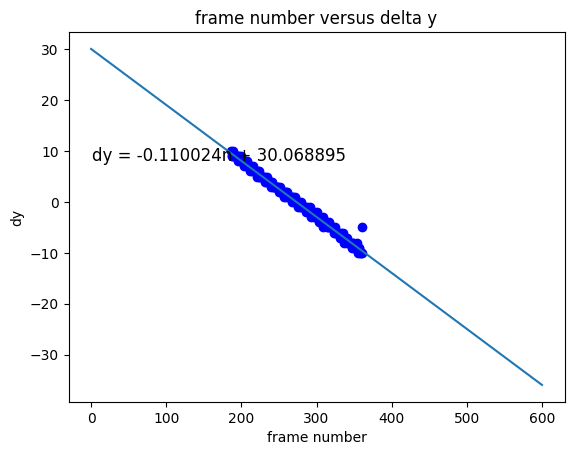

In [38]:
# Fit a linear regression line to the coordinates
coefficients = np.polyfit(frame_nos[:-1], delta_y, 1)
m, b = coefficients

# Generate x values for the plot
n = np.linspace(0, 600, 100)

# Calculate y values based on the linear equation
dy = m * n + b

# Plot the linear graph
plt.plot(n, dy, label='Linear Graph')

# Plot the original coordinates
plt.scatter(frame_nos[:-1], delta_y, color='blue', label='Coordinates')

# Print the equation on the graph
equation = f"dy = {m:.6f}n + {b:.6f}"
plt.text(1, 8, equation, fontsize=12)

plt.xlabel('frame number')
plt.ylabel('dy')
plt.title('frame number versus delta y')
plt.show()

Since this is the graph of verticle velocity, slope of this graph gives accelaratin due to gravity g = -0.110024 pixel/ frame squared

In [39]:
(-0.110024 / 797 ) / (1/(266.3 * 266.3))

-9.789746394680051

## **So g value found by video analysis is 9.79 m per seconds squared**